In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.ensemble
import sklearn.metrics
import sklearn.tree
import sklearn.base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hashlib
import os

np.random.seed(42)

# 02. 一个完整的机器学习项目
本章中，你会假装作为被一家地产公司刚刚雇佣的数据科学家，完整地学习一个案例项目。下面是主要步骤：
1. 项目概述。
2. 获取数据。
3. 发现并可视化数据，发现规律。
4. 为机器学习算法准备数据。
5. 选择模型，进行训练。
6. 微调模型。
7. 给出解决方案。
8. 部署、监控、维护系统。

## 2.1 使用真实数据
学习机器学习时，最好使用真实数据，而不是人工数据集。幸运的是，有上千个开源数据集可以进行选择，涵盖多个领域。以下是一些可以查找的数据的地方：
+ 流行的开源数据仓库：
    - [UC Irvine Machine Learning Repository](https://link.jianshu.com/?t=http%3A%2F%2Farchive.ics.uci.edu%2Fml%2F)
    - [Kaggle datasets](https://link.jianshu.com/?t=https%3A%2F%2Fwww.kaggle.com%2Fdatasets)
    - [Amazon’s AWS datasets](https://link.jianshu.com/?t=http%3A%2F%2Faws.amazon.com%2Ffr%2Fdatasets%2F)
+ 准入口(提供开源数据列表)
    - http://dataportals.org/
    - http://opendatamonitor.eu/
    - http://quandl.com/
+ 其它列出流行开源数据仓库的网页：
    - [Wikipedia’s list of Machine Learning datasets](https://link.jianshu.com/?t=https%3A%2F%2Fgoo.gl%2FSJHN2k)
    - [Quora.com question](https://link.jianshu.com/?t=http%3A%2F%2Fgoo.gl%2FzDR78y)
    - [Datasets subreddit](https://link.jianshu.com/?t=https%3A%2F%2Fwww.reddit.com%2Fr%2Fdatasets)

本章，我们选择的是StatLib的加州房产价格数据集(见`图2-1`)。这个数据集是基于1990年加州普查的数据。数据已经有点老(1990年还能买一个湾区不错的房子)，但是它有许多优点，利于学习，所以假设这个数据为最近的。为了便于教学，我们添加了一个类别属性，并除去了一些。

<img src="images/02_01.png" style="width:600px;"/>

## 2.2 项目概览
欢迎来到机器学习房地产公司！你的第一个任务是利用加州普查数据，建立一个加州房价模型。这个数据包含每个街区组的人口、收入中位数、房价中位数等指标。街区组是美国调查局发布样本数据的最小地理单位(一个街区通常有600到3000人）。我们将其简称为`街区`。

你的模型要利用这个数据进行学习，然后根据其它指标，预测任何街区的的房价中位数。

> 你是一个有条理的数据科学家，你要做的第一件事是拿出你的机器学习项目清单。你可以使用附录 B 中的清单；这个清单适用于大多数的机器学习项目，但是你还是要确认它是否满足需求。在本章中，我们会检查许多清单上的项目，但是也会跳过一些简单的，有些会在后面的章节再讨论。

### 2.2.1 划定问题
问老板的第一个问题应该是商业目标是什么？建立模型可能不是最终目标。公司要如何使用、并从模型受益？这非常重要，因为它决定了如何划定问题，要选择什么算法，评估模型性能的指标是什么，要花多少精力进行微调。

老板告诉你你的模型的输出(一个区的房价中位数)会传给另一个机器学习系统(见`图2-2`)，也有其它信号会传入后面的系统。这一整套系统可以确定某个区进行投资值不值。确定值不值得投资非常重要，它直接影响利润。

<img src="images/02_02.png" style="width:500px;"/>

> **流水线**
> 
> 一系列的数据处理组件被称为数据流水线。流水线在机器学习系统中很常见，因为有许多数据要处理和转换。
> 
> 组件通常是异步运行的。每个组件吸纳进大量数据，进行处理，然后将数据传输到另一个数据容器中，而后流水线中的另一个组件收入这个数据，然后输出，这个过程依次进行下去。每个组件都是独立的：组件间的接口只是数据容器。这样可以让系统更便于理解(记住数据流的图)，不同的项目组可以关注于不同的组件。进而，如果一个组件失效了，下游的组件使用失效组件最后生产的数据，通常可以正常运行(一段时间)。这样就使整个架构相当健壮。
> 
> 另一方面，如果没有监控，失效的组件会在不被注意的情况下运行一段时间。数据会受到污染，整个系统的性能就会下降。

下一个要问的问题是，现在的解决方案效果如何。老板通常会给一个参考性能，以及如何解决问题。老板说，现在街区的房价是靠专家手工估计的，专家队伍收集最新的关于一个区的信息(不包括房价中位数)，他们使用复杂的规则进行估计。这种方法费钱费时间，而且估计结果不理想，误差率大概有`15%`。

OK，有了这些信息，你就可以开始设计系统了。首先，你需要划定问题：监督或非监督，还是强化学习？这是个分类任务、回归任务，还是其它的？要使用批量学习还是线上学习？继续阅读之前，请暂停一下，尝试自己回答下这些问题。

你能回答出来吗？一起看下答案：很明显，这是一个典型的监督学习任务，因为你要使用的是有标签的训练样本(每个实例都有预定的产出，即街区的房价中位数)。并且，这是一个典型的回归任务，因为你要预测一个值。讲的更细些，这是一个`多变量回归`问题，因为系统要使用多个变量进行预测(要使用街区的人口，收入中位数等等)。在第一章中，你只是根据人均 GDP 来预测生活满意度，因此这是一个`单变量回归`问题。最后，没有连续的数据流进入系统，没有特别需求需要对数据变动作出快速适应。数据量不大可以放到内存中，因此批量学习就够了。

> 如果数据量很大，你可以要么在多个服务器上对批量学习做拆分(使用`MapReduce`技术，后面会看到)，或是使用线上学习。

### 2.2.2 选择性能指标
下一步是选择性能指标。回归问题的典型指标是`均方根误差`(RMSE)。均方根误差测量的是系统预测误差的标准差。例如，RMSE等于50000，意味着，`68%`的系统预测值位于实际值的50000美元以内，`95%`的预测值位于实际值的100000美元以内(一个特征通常都符合高斯分布，即满足`68-95-99.7`规则：大约`68%`的值落在$1\sigma$内，`95%`的值落在$2\sigma$内，`99.7%`的值落在$3\sigma$内，这里的$\sigma$等于50000）。`公式2-1`展示了计算RMSE的方法。

- $RMSE(X, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}$

**符号的含义**. 
这个方程引入了一些常见的贯穿本书的机器学习符号：
+ $m$是测量RMSE的数据集中的实例数量。例如，如果用一个含有2000个街区的验证集求RMSE，则$m = 2000$。

+ $x^{(i)}$是数据集第$i$个实例的所有特征值(不包含标签)的向量，$y^{(i)}$是它的标签(这个实例的输出值)。 例如，如果数据集中的第一个街区位于经度`-118.29°`，纬度`33.91°`，有`1416`名居民，收入中位数是`38372`美元，房价中位数是`156400`美元(忽略掉其它的特征)，则有：
    + $x^{(1)} = \begin{Bmatrix} -118.29 \\ 33.91 \\ 1416 \\ 38372  \end{Bmatrix}$，以及 $y^{(1)} = 156400$
    
+ $X$是包含数据集中所有实例的所有特征值(不包含标签)的矩阵。每一行是一个实例，第$i$行是$x^{(i)}$的转置，记为$(x^{(i)})^T$。例如，仍然是前面提到的第一区，矩阵$X$就是：
    + $X= \begin{Bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ ... \\ (x^{(1999)})^T \\ (x^{(2000)})^T  \end{Bmatrix} = \begin{Bmatrix} -118.29 & 33.91 & 1416 & 38372 \\ \vdots & \vdots & \vdots & \vdots \end{Bmatrix}$

+ $h$是系统的预测函数，也称为`假设`(hypothesis)。当系统收到一个实例的特征向量$x^{(i)}$，就会输出这个实例的一个预测值$\hat y^{(i)} = h(x^{(i)})$($\hat y$读作`y-hat`)。
    - 例如，如果系统预测第一区的房价中位数是`158400`美元，则$\hat y^{(1)} = h(x^{(1)}) = 158400$。预测误差是$\hat y^{(1)} - y^{(1)} = 2000$。

+ $RMSE(X,h)$是使用假设$h$在样本集上测量的损失函数。

虽然大多数时候RMSE是回归任务可靠的性能指标，在有些情况下，你可能需要另外的函数。例如，假设存在许多异常值的街区。此时，你可能需要使用`平均绝对误差`(Mean Absolute Error，也称作平均绝对偏差)，见`公式2-2`：
+ $MAE(X, h) = \frac{1}{m}\sum_{i=1}^{m}|h(x^{(i)}) - y^{(i)}|$

RMSE和MAE都是测量预测值和目标值两个向量距离的方法。有多种测量距离的方法，或范数：
+ 计算对应欧几里得范数的平方和的根(RMSE)：这个距离介绍过。它也称作$\ell_2$范数，标记为$\Vert \cdot \Vert_2$(或只是$\Vert \cdot \Vert$)。
+ 计算对应于$\ell_1$(标记为$\Vert \cdot \Vert_1$)范数的`绝对值和`(MAE)。有时，也称其为曼哈顿范数，因为它测量了城市中的两点，沿着矩形的边行走的距离。
+ 更一般的，包含$n$个元素的向量$\mathrm{v}$的$\ell_k$范数(K阶闵氏范数)，定义成$\Vert \mathrm{v} \Vert_k = (|v_0|^k + |v_1|^k + ... + |v_n|^k)^{\frac{1}{k}}$。$\ell_0$(汉明范数)只显示了这个向量的基数(即，非零元素的个数)，$\ell_{\infty}$(切比雪夫范数)是向量中最大的绝对值。
+ 范数的指数越高，就越关注大的值而忽略小的值。这就是为什么RMSE比MAE对异常值更敏感。但是当异常值是指数分布的(类似正态曲线)，RMSE就会表现很好。

### 2.2.3 核实假设
最后，最好列出并核对迄今(你或其他人)作出的假设，这样可以尽早发现严重的问题。例如，你的系统输出的街区房价，会传入到下游的机器学习系统，我们假设这些价格确实会被当做街区房价使用。但是如果下游系统实际上将价格转化成了分类(例如，便宜、中等、昂贵)，然后使用这些分类，而不是使用价格。这样的话，获得准确的价格就不那么重要了，你只需要得到合适的分类。问题相应地就变成了一个分类问题，而不是回归任务。你可不想在一个回归系统上工作了数月，最后才发现真相。

幸运的是，在与下游系统主管探讨之后，你很确信他们需要的就是实际的价格，而不是分类。很好！整装待发，可以开始写代码了。

## 2.3 获取数据
开始动手。最后用Jupyter notebook完整地敲一遍示例代码。

### 2.3.1 创建工作空间
[略]

### 2.3.2 下载数据
一般情况下，数据是存储于关系型数据库(或其它常见数据库)中的多个表、文档、文件。要访问数据，你首先要有密码和登录权限，并要了解数据模式。但是在这个项目中，这一切要简单些：只要下载一个压缩文件，`housing.tgz`，它包含一个CSV文件`housing.csv`，含有所有数据。

下面是获取数据的函数：
```python
import os 
import tarfile 
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = "datasets/housing" 
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) 
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path) 
    housing_tgz.close()
```

然后使用Pandas加载数据。还是用一个小函数来加载数据：

In [2]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, "datasets/housing.csv") 
    return pd.read_csv(csv_path)

这个函数会返回一个包含所有数据的 Pandas DataFrame 对象。

### 2.3.3 快速查看数据结构
使用DataFrame的`head()`方法查看该数据集的前5行。

In [3]:
housing = load_housing_data("")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


每一行都表示一个街区。共有10个属性：经度、维度、房屋年龄中位数、总房间数、总卧室数、人口数、家庭数、收入中位数、房屋价值中位数、离大海距离。

`info()`方法可以快速查看数据的描述，特别是总行数、每个属性的类型和非空值的数量：

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


数据集中共有20640个实例，按照机器学习的标准这个数据量很小，但是非常适合入门。我们注意到总卧室数只有20433个非空值，这意味着有207个街区缺少这个值。我们将在后面对它进行处理。

所有的属性都是数值的，除了离大海距离(`ocean_proximity`)这项。它的类型是对象，因此可以包含任意Python对象，但是因为该项是从CSV文件加载的，所以必然是文本类型。在刚才查看数据前五项时，你可能注意到那一列的值是重复的，意味着它可能是一项表示类别的属性。可以使用`value_counts()`方法查看该项中都有哪些类别，每个类别中都包含有多少个街区：

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

再来看其它字段。`describe()`方法展示了数值属性的概括：

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`count`、`mean`、`min`和`max`几行的意思很明显了。注意，空值被忽略了(所以，卧室总数是20433而不是20640)。`std`是标准差(揭示数值的分散度)。`25%`、`50%`、`75%`展示了对应的分位数：每个分位数指明小于这个值，且指定分组的百分比。例如，`25%`的街区的房屋年龄中位数小于18，而`50%`的小于29，`75%`的小于37。这些值通常称为第25个百分位数(或第一个四分位数)，中位数，第75个百分位数(第三个四分位数)。

另一种快速了解数据类型的方法是画出每个数值属性的`柱状图`。柱状图(的纵轴)展示了特定范围的实例的个数。你还可以一次给一个属性画图，或对完整数据集调用`hist()`方法，后者会画出每个数值属性的柱状图。例如，你可以看到略微超过800个街区的`median_house_value`值差不多等于500000美元。

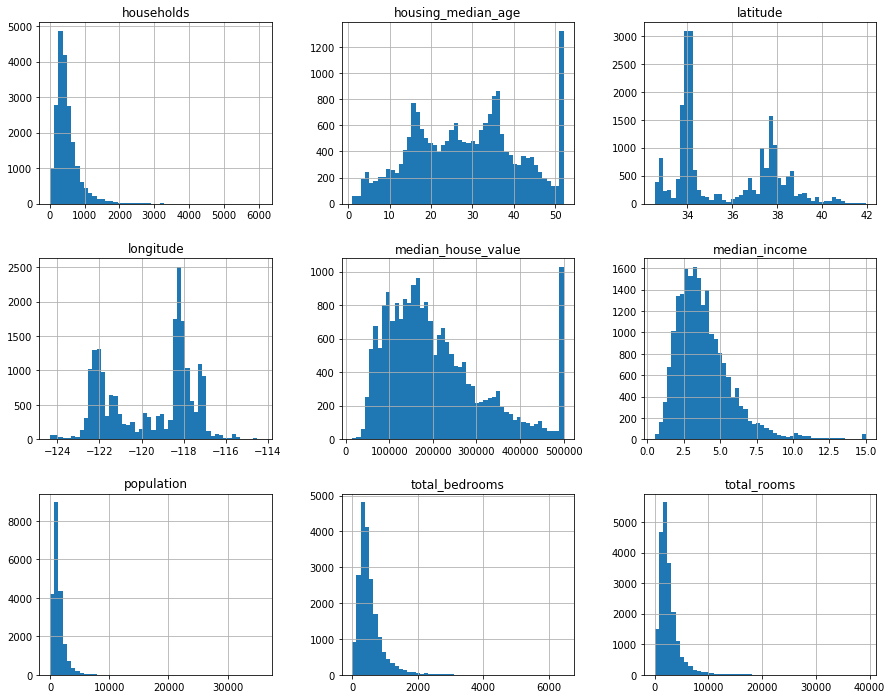

In [7]:
housing.hist(bins=50, figsize=(15,12)) 
plt.show()

> `hist()`方法依赖于Matplotlib，后者依赖于用户指定的图形后端以打印到屏幕上。因此在画图之前，你要指定Matplotlib要使用的后端。最简单的方法是使用Jupyter的魔术命令`%matplotlib inline`。它会告诉Jupyter设定好Matplotlib，以使用Jupyter自己的后端。绘图就会在notebook中渲染了。注意在Jupyter中调用`show()`不是必要的，因为代码框执行后Jupyter会自动展示图像。

注意柱状图中的一些点：
1. 首先，收入中位数貌似不是美元(USD)。与数据采集团队交流之后，你被告知数据是经过缩放调整的，过高收入中位数的会变为15(实际为15.0001)，过低的会变为0.5(实际为0.4999)。在机器学习中对数据进行预处理很正常，这不一定是个问题，但你要明白数据是如何计算出来的。
2. 房屋年龄中位数和房屋价值中位数也被设了上限。后者可能是个严重的问题，因为它是你的目标属性(你的标签)。你的机器学习算法可能学习到价格不会超出这个界限。你需要与下游团队核实，这是否会成为问题。如果他们告诉你他们需要明确的预测值，即使超过500000美元，你则有两个选项：
    - 对于设了上限的标签，重新收集合适的标签；
    - 将这些街区从训练集移除(也从测试集移除，因为若房价超出500000美元，你的系统就会被差评)????翻译似乎不准确！！！。
3. 这些属性值有不同的量度。我们会在本章后面讨论特征缩放。
4. 最后，许多柱状图的尾巴很长：相较于左边，它们在中位数的右边延伸过远。对于某些机器学习算法，这会使检测规律变得更难些。我们会在后面尝试变换处理这些属性，使其变为`正态分布`。

希望你现在对要处理的数据有一定了解了。

> 稍等！在你进一步查看数据之前，你需要创建一个测试集，将它放在一旁，千万不要再看它。

### 2.3.4 创建测试集
在这个阶段就分割数据，听起来很奇怪。毕竟，你只是简单快速地查看了数据而已，你需要再仔细调查下数据以决定使用什么算法。这么想是对的，但是人类的大脑是一个神奇的发现规律的系统，这意味着大脑非常容易发生过拟合：如果你查看了测试集，就会不经意地按照测试集中的规律来选择某个特定的机器学习模型。再当你使用测试集来评估误差率时，就会导致评估过于乐观，而实际部署的系统表现就会差。这称为`数据透视偏差`。

理论上，创建测试集很简单：只要随机挑选一些实例，一般是数据集的`20%`，放到一边：

In [8]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


这个方法可行，但是并不完美：如果再次运行程序，就会产生一个不同的测试集！多次运行之后，你(或你的机器学习算法)就会得到整个数据集，这是需要避免的。

解决的办法之一是保存第一次运行得到的测试集，并在随后的过程加载。另一种方法是在调用`np.random.permutation()`之前，设置随机数生成器的种子(比如`np.random.seed(42)`)，以产生总是相同的`洗牌指数`(shuffled indices)。

但是如果数据集更新，这两个方法都会失效。一个通常的解决办法是使用每个实例的ID来判定这个实例是否应该放入测试集(假设每个实例都有唯一并且不变的ID)。例如，你可以计算出每个实例ID的哈希值，只保留其最后一个字节，如果该值小于等于51(约为256的`20%`)，就将其放入测试集。这样可以保证在多次运行中，测试集保持不变，即使更新了数据集。新的测试集会包含新实例中的`20%`，但不会有之前位于训练集的实例。下面是一种可用的方法：

In [9]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

不过，房产数据集没有ID这一列。最简单的方法是使用行索引作为ID：

In [10]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


如果使用行索引作为唯一识别码，你需要保证新数据都放到现有数据的尾部，且没有行被删除。如果做不到，则可以用最稳定的特征来创建唯一识别码。例如，一个区的维度和经度在几百万年之内是不变的，所以可以将两者结合成一个ID：

In [11]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


`Scikit-Learn`提供了一些函数，可以用多种方式将数据集分割成多个子集。最简单的函数是`train_test_split`，它的作用和之前的函数`split_train_test`很像，并带有其它一些功能。首先，它有一个`random_state`参数，可以设定前面讲过的随机生成器种子；第二，你可以将种子传递给多个行数相同的数据集，可以在相同的索引上分割数据集(这个功能非常有用，比如你的标签值是放在另一个`DataFrame`里的)：

In [12]:
train_set, test_set = sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


目前为止，我们采用的都是纯随机的取样方法。当你的数据集很大时(尤其是和属性数相比)，这通常可行；但如果数据集不大，就会有采样偏差的风险。当一个调查公司想要对1000个人进行调查，它们不是在电话亭里随机选1000个人出来。调查公司要保证这1000个人对人群整体有代表性。例如，美国人口的`51.3%`是女性，`48.7%`是男性。所以在美国，严谨的调查需要保证样本也是这个比例：513名女性，487名男性。这称作`分层采样`(stratified sampling)：将人群分成均匀的子分组，称为`分层`，从每个`分层`去取合适数量的实例，以保证测试集对总人数有代表性。如果调查公司采用纯随机采样，会有`12%`的概率导致采样偏差：女性人数少于`49%`，或多于`54%`。不管发生那种情况，调查结果都会严重偏差。

假设专家告诉你，收入中位数是预测房价中位数非常重要的属性。你可能想要保证测试集可以代表整体数据集中的多种收入分类。因为收入中位数是一个连续的数值属性，你首先需要创建一个收入类别属性。再仔细地看一下收入中位数的柱状图(`图2-9`)(译注：该图是对收入中位数处理过后的图)：
<img src="images/02_09.png" style="width:500px;"/>

原始数据的图如下：

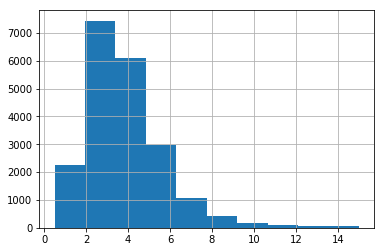

In [13]:
housing["median_income"].hist()
plt.show()

大多数的收入中位数的值聚集在2-5(万美元)，但是一些收入中位数会超过6。数据集中的每个分层都要有足够的实例位于你的数据中，这点很重要。否则，对分层重要性的评估就会有偏差。这意味着，你不能有过多的分层，且每个分层都要足够大。后面的代码通过将收入中位数除以1.5(以限制收入分类的数量)，创建了一个收入类别属性，用`ceil`对值舍入(以产生离散的分类)，然后将所有大于5的分类归入到分类5：

In [14]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

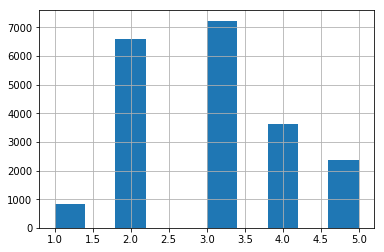

In [15]:
housing["income_cat"].hist()
plt.show()

现在，就可以根据收入分类，进行分层采样。你可以使用`Scikit-Learn`的`StratifiedShuffleSplit`类：

In [16]:
split = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

使用相似的代码，还可以测量测试集中收入分类的比例。`图2-10`对比了总数据集、分层采样的测试集、纯随机采样测试集的收入分类比例。可以看到，分层采样测试集的收入分类比例与总数据集几乎相同，而随机采样数据集偏差严重。

<img src="images/02_10.png" style="width:600px;"/>

现在，你需要删除`income_cat`属性，使数据回到初始状态：

In [17]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

我们用了大量时间来生成测试集的原因是：测试集通常被忽略，但实际是机器学习非常重要的一部分。还有，生成测试集过程中的许多思路对于后面的交叉验证讨论是非常有帮助的。接下来进入下一阶段：数据探索。

## 2.4 数据探索和可视化、发现规律
目前为止，你只是快速查看了数据，对要处理的数据有了整体了解。现在的目标是更深的探索数据。

首先，保证你将测试集放在了一旁，只是研究训练集。另外，如果训练集非常大，你可能需要再采样一个探索集，保证操作方便快速。在我们的案例中，数据集很小，所以可以在全集上直接工作。创建一个副本，以免损伤训练集：

In [18]:
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


### 2.4.1 地理数据可视化
因为存在地理信息(纬度和经度)，创建一个所有街区的散点图来数据可视化是一个不错的主意：

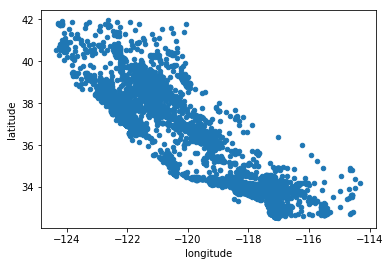

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

这张图看起来很像加州，但是看不出什么特别的规律。将`alpha`设为`0.1`，可以更容易看出数据点的密度：

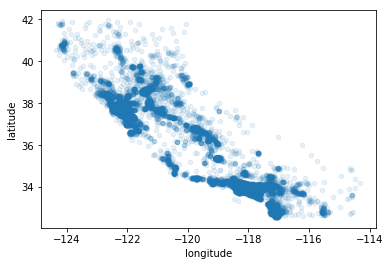

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

现在看起来好多了：可以非常清楚地看到高密度区域，湾区、洛杉矶和圣迭戈，以及中央谷，特别是从萨克拉门托和弗雷斯诺。

通常来讲，人类的大脑非常善于发现图片中的规律，但是需要调整可视化参数使规律显现出来。

现在来看房价。每个圈的半径表示街区的人口(选项s)，颜色代表价格(选项c)。我们用预先定义的名为`jet`的颜色图(选项cmap)，它的范围是从蓝色(低价)到红色(高价)：

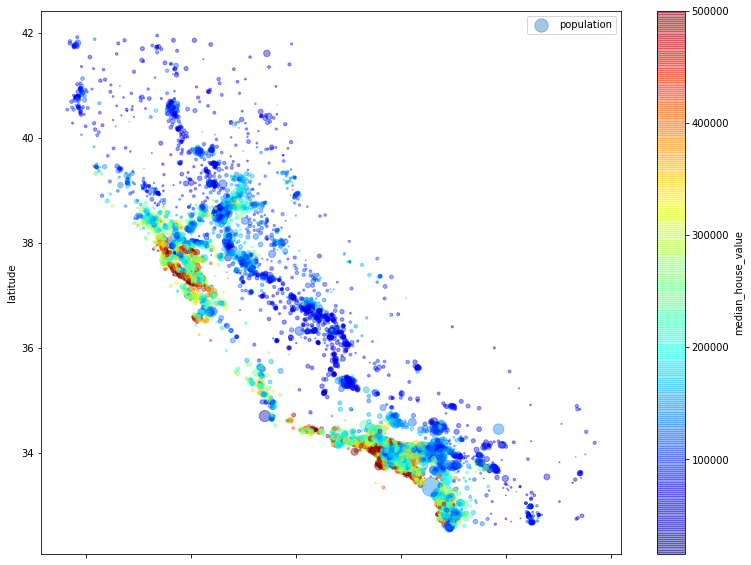

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", colorbar=True,
             alpha=0.4, figsize=(13,10), label="population", 
             s=housing["population"]/100, 
             c="median_house_value", 
             cmap=plt.get_cmap("jet"), ) 
plt.legend()
plt.show()

这张图说明房价和位置(比如，靠海)和人口密度联系密切，这点你可能早就知道。可以使用聚类算法来检测主要的聚集，用一个新的特征值测量聚集中心的距离。尽管北加州海岸区域的房价不是非常高，但离大海距离属性也可能很有用，所以这不是用一个简单的规则就可以定义的问题。

### 2.4.2 查找关联
因为数据集并不是非常大，你可以很容易地使用`corr()`方法计算出每对属性间的`标准相关系数`(standard correlation coefficient，也称作`皮尔逊相关系数`)：

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

相关系数的范围是-1到1。当接近1时，意味强正相关；例如，当收入中位数增加时，房价中位数也会增加。当相关系数接近-1时，意味强负相关；你可以看到，纬度和房价中位数有轻微的负相关性(即，越往北，房价越可能降低)。最后，相关系数接近0，意味没有线性相关性。`图2-14`展示了相关系数在横轴和纵轴之间的不同图形。

<img src="images/02_14.png" style="width:500px;"/>

> 相关系数只测量线性关系(如果$x$上升，$y$则上升或下降)。相关系数可能会完全忽略非线性关系(例如，如果$x$接近 0，则$y$值会变高)。在上面图片的最后一行中，他们的相关系数都接近于0，尽管它们的轴并不独立：这些就是非线性关系的例子。另外，第二行的相关系数等于1或-1；这和斜率没有任何关系。例如，你的身高(单位是英寸)与身高(单位是英尺或纳米)的相关系数就是1。

另一种检测属性间相关系数的方法是使用Pandas的`scatter_matrix`函数，它能画出每个数值属性对每个其它数值属性的图。因为现在共有11个数值属性，你可以得到$11^2 = 121$张图，在一页上画不下，所以只关注几个和房价中位数最有可能相关的属性：

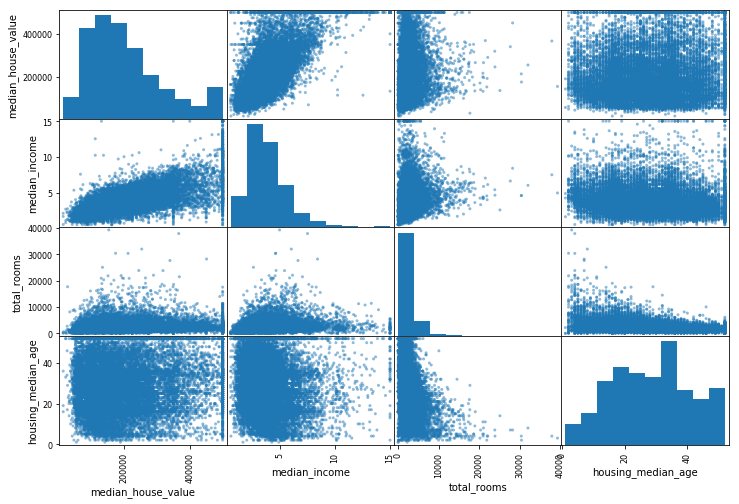

In [23]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] 
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

如果Pandas将每个变量对自己作图，主对角线(左上到右下)都会是直线图。所以Pandas展示的是每个属性的柱状图(也可以是其它的，请参考Pandas文档)。

最有希望用来预测房价中位数的属性是收入中位数，因此将这张图放大：

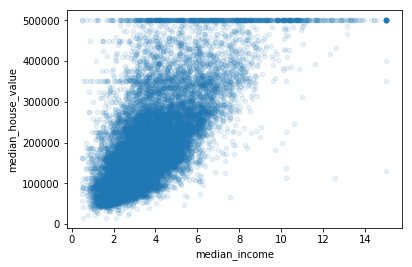

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

这张图说明了几点。首先，相关性非常高；可以清晰地看到向上的趋势，并且数据点不是非常分散。第二，我们之前看到的最高价，清晰地呈现为一条位于500000美元的水平线。这张图也呈现了一些不是那么明显的直线：一条位于450000美元的直线，一条位于350000美元的直线，一条在280000美元的线，和一些更靠下的线。你可能希望去除对应的街区，以防止算法重复这些巧合。

### 2.4.3 属性组合试验
希望前面的一节能教给你一些探索数据、发现规律的方法。你发现了一些数据的巧合，需要在给算法提供数据之前，将其去除。你还发现了一些属性间有趣的关联，特别是目标属性。你还注意到一些属性具有长尾分布，因此你可能要将其进行转换(例如，计算其log对数)。当然，不同项目的处理方法各不相同，但大体思路是相似的。

给算法准备数据之前，你需要做的最后一件事是尝试多种属性组合。例如，如果你不知道某个街区有多少户，该街区的总房间数就没什么用。你真正需要的是每户有几个房间。相似的，总卧室数也不重要：你可能需要将其与房间数进行比较。每户的人口数也是一个有趣的属性组合。让我们来创建这些新的属性：

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household"]=housing["population"]/housing["households"]

现在，再来看相关矩阵：

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

看起来不错！与总房间数或卧室数相比，新的`bedrooms_per_room`属性与房价中位数的关联更强。显然，`卧室数/总房间数`的比例越低，房价就越高。每户的房间数也比街区的总房间数的更有信息，很明显，房屋越大，房价就越高。

这一步的数据探索不必非常完备，此处的目的是有一个正确的开始，快速发现规律，以得到一个合理的原型。但是这是一个交互过程：一旦你得到了一个原型，并运行起来，你就可以分析它的输出，进而发现更多的规律，然后再回到数据探索这步。

## 2.5 为机器学习算法准备数据
现在来为机器学习算法准备数据。不要手工来做，你需要写一些函数，理由如下：
+ 函数可以让你在任何数据集上(比如，你下一次获取的是一个新的数据集)方便地进行重复数据转换。
+ 你能慢慢建立一个转换函数库，可以在未来的项目中复用。
+ 在将数据传给算法之前，你可以在实时系统中使用这些函数。
+ 这可以让你方便地尝试多种数据转换，查看哪些转换方法结合起来效果最好。

但是，还是先回到干净的训练集(通过再次复制`strat_train_set`)，将预测量和标签分开，因为我们不想对预测量和目标值应用相同的转换(注意`drop()`创建了一份数据的备份，而不影响`strat_train_set`)：

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1 数据清洗
大多机器学习算法不能处理缺失的特征，因此先创建一些函数来处理特征缺失的问题。前面，你应该注意到了属性`total_bedrooms`有一些缺失值。有三个解决选项：
1.  去掉对应的街区；
2. 去掉整个属性；
3. 进行赋值(0、平均值、中位数等等)。

用DataFrame的`dropna()`，`drop()`，和`fillna()`方法，可以方便地实现：
```python
housing.dropna(subset=["total_bedrooms"])   # option 1
housing.drop("total_bedrooms", axis=1)      # option 2
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median)    # option 3
```

如果选择选项3，你需要计算训练集的中位数，用中位数填充训练集的缺失值，不要忘记保存该中位数。后面用测试集评估系统时，需要替换测试集中的缺失值，也可以用来实时替换新数据中的缺失值。

`Scikit-Learn`提供了一个方便的类来处理缺失值：`Imputer`。下面是其使用方法：首先，需要创建一个`Imputer`实例，指定用某属性的中位数来替换该属性所有的缺失值：

In [28]:
imputer = sklearn.preprocessing.Imputer(strategy="median")

# 因为只有数值属性才能算出中位数，我们需要创建一份不包括文本属性ocean_proximity的数据副本
housing_num = housing.drop("ocean_proximity", axis=1)
# 用fit()方法将imputer实例拟合到训练数据
imputer.fit(housing_num)

# imputer计算出了每个属性的中位数，并将结果保存在了实例变量statistics_中
print("median of each attribute: ", housing_num.median().values)

# 虽然此时只有属性total_bedrooms存在缺失值，但我们不能确定在以后的新的数据中会不会有其他
# 属性也存在缺失值，所以安全的做法是将imputer应用到每个数值
#
# 使用这个“训练过的”imputer来对训练集进行转换，将缺失值替换为中位数
X = imputer.transform(housing_num)

# 结果X是一个包含转换后特征的普通的Numpy数组。如果你想将其放回到Pandas的DataFrame中
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

median of each attribute:  [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


> **Scikit-Learn 设计**
> `Scikit-Learn`的API设计的非常好。它的主要设计原则是：
> + 一致性：所有对象的接口一致且简单：
>     - 估计器(estimator)。任何可以基于数据集对一些参数进行估计的对象都被称为估计器(比如，imputer就是个估计器)。估计本身是通过`fit()`方法，只需要一个数据集作为参数(对于监督学习算法，需要两个数据集；第二个数据集包含标签)。任何其它用来指导估计过程的参数都被当做`超参数`(比如imputer的strategy)，并且超参数要被设置成实例变量(通常通过构造器参数设置)。
>     - 转换器(transformer)。一些估计器(比如imputer)也可以转换数据集，这些估计器被称为转换器。API也是相当简单：转换是通过`transform()`方法，被转换的数据集作为参数。返回的是经过转换的数据集。转换过程依赖学习到的参数，比如imputer的例子。所有的转换都有一个便捷的方法`fit_transform()`，等同于调用`fit()`再`transform()`(但有时`fit_transform()`经过优化，运行的更快)。
>     - 预测器(predictor)。最后，一些估计器可以根据给出的数据集做预测，这些估计器称为预测器。例如，上一章的LinearRegression模型就是一个预测器：它根据一个国家的人均GDP预测生活满意度。预测器有一个`predict()`方法，可以用新实例的数据集做出相应的预测。预测器还有一个`score()`方法，可以根据测试集(和相应的标签，如果是监督学习算法的话)对预测进行衡量。
> + 可检验。所有估计器的超参数都可以通过实例的public变量直接访问(比如，imputer.strategy)，并且所有估计器学习到的参数也可以通过在实例变量名后加下划线来访问(比如，imputer.statistics_)。
> + 类不可扩散。数据集被表示成NumPy数组或SciPy稀疏矩阵，而不是自制的类。超参数只是普通的Python字符串或数字。
> + 可组合。尽可能使用现存的模块。例如，用任意的转换器序列加上一个估计器，就可以做成一个流水线，后面会看到例子。
> + 合理的默认值。Scikit-Learn给大多数参数提供了合理的默认值，很容易就能创建一个系统。

### 2.5.2 处理文本和类别属性
前面，我们丢弃了类别属性`ocean_proximity`，因为它是一个文本属性，不能计算出中位数。大多数机器学习算法更喜欢和数字打交道，所以让我们把这些文本标签转换为数字。

`Scikit-Learn`为这个任务提供了一个转换器`LabelEncoder`：

In [29]:
encoder = sklearn.preprocessing.LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded.shape

(16512,)

> **译注**
> 在原书中使用LabelEncoder转换器来转换文本特征列的方式是错误的，该转换器只能用来转换标签(正如其名)。在这里使用LabelEncoder没有出错的原因是该数据只有一列文本特征值，在有多个文本特征列的时候就会出错。应使用`factorize()`方法来进行操作：
> ```python
> housing_cat_encoded, housing_categories = housing_cat.factorize()
> ```

好了一些，现在就可以在任何机器学习算法里用这个数值数据了。你可以查看映射表，编码器是通过属性`classes_`来学习的(`<1H OCEAN`被映射为0，`INLAND`被映射为 1，等等）：

In [30]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

这种做法的问题是，机器学习算法会认为两个临近的值比两个疏远的值要更相似。显然这样不对(比如，分类0和4比0和1更相似)。要解决这个问题，一个常见的方法是给每个分类创建一个二元属性：当分类是`<1H OCEAN`，该属性为1(否则为0)，当分类是`INLAND`，另一个属性等于1(否则为0)，以此类推。这称作`独热编码`(One-Hot Encoding)，因为只有一个属性会等于1(热)，其余会是0(冷)。

`Scikit-Learn`提供了一个编码器`OneHotEncoder`，用于将整数分类值转变为独热向量。注意`fit_transform()`用于2D数组，而`housing_cat_encoded`是一个1D数组，所以需要将其变形：

In [31]:
encoder = sklearn.preprocessing.OneHotEncoder()

# reshape() function allows one dimension to be –1, which means 
# “unspecified”: the value is inferred from the length of the array 
# and the remaining dimensions
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

注意输出结果是一个SciPy稀疏矩阵，而不是NumPy数组。当类别属性有数千个分类时，这样非常有用。经过独热编码，我们得到了一个有数千列的矩阵，这个矩阵每行只有一个1，其余都是0。使用大量内存来存储这些0非常浪费，所以稀疏矩阵只存储非零元素的位置。你可以像一个2D数据那样进行使用，但是如果你真的想将其转变成一个(密集的)NumPy 数组，只需调用`toarray()`方法：

In [32]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

使用类`LabelBinarizer`，我们可以用一步执行这两个转换(从文本分类到整数分类，再从整数分类到独热向量)：

In [33]:
encoder = sklearn.preprocessing.LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

注意默认返回的结果是一个密集NumPy数组。向构造器`LabelBinarizer`传递`sparse_output=True`，就可以得到一个稀疏矩阵。

> **译注**
> 在原书中使用LabelBinarizer的方式也是错误的，该类也应用于标签列的转换。正确做法是使用sklearn即将提供的CategoricalEncoder类。
> ```python
> from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn
> cat_encoder = CategoricalEncoder()
> housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
> housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
> housing_cat_1hot
> ```

[参考文章](https://jorisvandenbossche.github.io/blog/2017/11/20/categorical-encoder/)

### 2.5.3 自定义转换器
尽管`Scikit-Learn`提供了许多有用的转换器，你还是需要自己动手写转换器执行任务，比如自定义的清理操作，或属性组合。你需要让自制的转换器与`Scikit-Learn`组件(比如流水线)无缝衔接工作，因为`Scikit-Learn`是依赖鸭子类型的(而不是继承)，你所需要做的是创建一个类并执行三个方法：`fit()`(返回self)，`transform()`，和`fit_transform()`。通过添加`TransformerMixin`作为基类，可以很容易地得到最后一个。另外，如果你添加`BaseEstimator`作为基类(且构造器中避免使用`*args`和`**kargs`)，你就能得到两个额外的方法(`get_params()`和`set_params()`)，二者可以方便地进行超参数自动微调。例如，一个小转换器类添加了上面讨论的属性：

In [34]:
# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

在这个例子中，转换器有一个超参数`add_bedrooms_per_room`，默认设为`True`(提供一个合理的默认值很有帮助)。这个超参数可以让你方便地发现添加了这个属性是否对机器学习算法有帮助。更一般地，你可以为每个不能完全确保的数据准备步骤添加一个超参数。数据准备步骤越自动化，可以自动化的操作组合就越多，越容易发现更好用的组合(并能节省大量时间)。

### 2.5.4 特征缩放
数据要做的最重要的转换之一是`特征缩放`。除了个别情况，当输入的数值属性量度不同时，机器学习算法的性能都不会好。这个规律也适用于房产数据：总房间数分布范围是6到39320，而收入中位数只分布在0到15。注意通常情况下我们不需要对目标值进行缩放。

有两种常见的方法可以让所有的属性有相同的量度：`线性函数归一化`(Min-Max scaling)和`标准化`(standardization)。

线性函数归一化(许多人称其为`归一化` normalization)很简单：值被转变、重新缩放，直到范围变成0到1。我们通过减去最小值，然后再除以最大值与最小值的差值，来进行归一化。`Scikit-Learn`提供了一个转换器`MinMaxScaler`来实现这个功能。它有一个超参数`feature_range`，可以让你改变范围，如果不希望范围是0到1。

标准化就很不同：首先减去平均值(所以标准化值的平均值总是0)，然后除以方差，使得到的分布具有单位方差。与归一化不同，标准化不会限定值到某个特定的范围，这对某些算法可能构成问题(比如，神经网络常需要输入值得范围是0到1)。但是，标准化受到异常值的影响很小。例如，假设一个街区的收入中位数由于某种错误变成了100，归一化会将其它范围是0到15的值变为`0-0.15`，但是标准化不会受什么影响。`Scikit-Learn`提供了一个转换器`StandardScaler`来进行标准化。

> 与所有的转换一样，缩放器只能向训练集拟合，而不是向完整的数据集(包括测试集)。只有这样，你才能用缩放器转换训练集和测试集(和新数据)。

### 2.5.5 转换流水线
你已经看到，存在许多数据转换步骤，需要按一定的顺序执行。幸运的是，`Scikit-Learn`提供了类`Pipeline`，来进行这一系列的转换。下面是一个数值属性的小流水线：

In [35]:
num_pipeline = sklearn.pipeline.Pipeline([
    ('imputer', sklearn.preprocessing.Imputer(strategy="median")), 
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', sklearn.preprocessing.StandardScaler()), ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Pipeline构造器需要一个定义步骤顺序的名字/估计器对的列表。除了最后一个估计器，其余都要是转换器(即，它们都要有`fit_transform()`方法)。名字可以随意起。

当你调用流水线的`fit()`方法，就会对所有转换器顺序调用`fit_transform()`方法，将每次调用的输出作为参数传递给下一个调用，一直到最后一个估计器，它只执行`fit()`方法。

流水线暴露相同的方法作为最终的估计器。在这个例子中，最后的估计器是一个`StandardScaler`，它是一个转换器，因此这个流水线有一个`transform()`方法，可以顺序对数据做所有转换(它还有一个`fit_transform`方法可以使用，就不必先调用`fit()`再进行`transform()`)。

[**下面的内容在第二版有了较大改动，参考原书**]
你现在就有了一个对数值的流水线，你还需要对分类值应用`LabelBinarizer`：如何将这些转换写成一个流水线呢？`Scikit-Learn`提供了一个类`FeatureUnion`实现这个功能。你给它一列转换器(可以是所有的转换器)，当调用它的`transform()`方法，每个转换器的`transform()`会被并行执行，等待输出，然后将输出合并起来，并返回结果(当然，调用它的`fit()`方法就会调用每个转换器的`fit()`）。一个完整的处理数值和类别属性的流水线如下所示：

In [36]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class MyLabelBinarizer(sklearn.base.TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = sklearn.preprocessing.LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = sklearn.pipeline.Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', sklearn.preprocessing.Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', sklearn.preprocessing.StandardScaler()),
    ])

cat_pipeline = sklearn.pipeline.Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
    ])

full_pipeline = sklearn.pipeline.FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

每个子流水线都以一个选择转换器开始：通过选择对应的属性(数值或分类)、丢弃其它的，来转换数据，并将输出DataFrame转变成一个NumPy数组。`Scikit-Learn`没有工具来处理Pandas的DataFrame，因此我们需要写一个简单的自定义转换器`DataFrameSelector`来做这项工作。

## 2.6 选择并训练模型
可到这一步了！你在前面限定了问题、获得了数据、探索了数据、采样了一个测试集、写了自动化的转换流水线来清理和为算法准备数据。现在，你已经准备好选择并训练一个机器学习模型了。

### 2.6.1 在训练集上训练和评估
好消息是基于前面的工作，接下来要做的比你想的要简单许多。像前一章那样，我们先来训练一个线性回归模型：

In [38]:
lin_reg = sklearn.linear_model.LinearRegression() 
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

完毕！你现在就有了一个可用的线性回归模型。用一些训练集中的实例做下验证：

In [39]:
# try it out on a few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


行的通，尽管预测并不怎么准确(比如，第二个预测偏离了`50%`)。让我们使用`Scikit-Learn`的`mean_squared_error`函数，用全部训练集来计算下这个回归模型的RMSE：

In [40]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

OK，有总比没有强，但显然结果并不好：大多数街区的`median_housing_values`位于120000到265000美元之间，因此预测误差`68628`美元不能让人满意。这是一个模型欠拟合训练数据的例子。当这种情况发生时，意味着特征没有提供足够多的信息来做出一个好的预测，或者模型并不强大。就像前一章看到的，修复欠拟合的主要方法是选择一个更强大的模型，给训练算法提供更好的特征，或去掉模型上的限制。这个模型还没有正则化，所以排除了最后一个选项。你可以尝试添加更多特征(比如，人口的对数值)，但是首先让我们尝试一个更为复杂的模型，看看效果。

来训练一个`DecisionTreeRegressor`。这是一个强大的模型，可以发现数据中复杂的非线性关系(决策树会在`第6章`详细讲解)。代码看起来很熟悉：

In [41]:
tree_reg = sklearn.tree.DecisionTreeRegressor() 
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

等一下，发生了什么？没有误差？这个模型可能是绝对完美的吗？当然，更大可能性是这个模型严重过拟合数据。如何确定呢？如前所述，直到你准备运行一个具备足够信心的模型，都不要碰测试集，因此你需要使用训练集的部分数据来做训练，用一部分来做模型验证。

### 2.6.2 使用交叉验证做更佳的评估
评估决策树模型的一种方法是用函数`train_test_split`来分割训练集，得到一个更小的训练集和一个验证集，然后用更小的训练集来训练模型，用验证集来评估。这需要一定工作量，并不难而且也可行。

另一种更好的方法是使用`Scikit-Learn`的交叉验证功能。下面的代码采用了`K折交叉验证`(K-fold cross-validation)：它随机地将训练集分成十个不同的子集，成为`折`，然后训练评估决策树模型10次，每次选一个不用的折来做评估，用其它9个来做训练。结果是一个包含10个评分的数组：

In [42]:
scores = sklearn.model_selection.cross_val_score(tree_reg, housing_prepared, 
                                                 housing_labels, scoring="neg_mean_squared_error", 
                                                 cv=10) 
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean: 70666.74616904806
Standard deviation: 2928.322738055112


> **警告**
> `Scikit-Learn`交叉验证功能期望的是`效用函数`(utility function, 越大越好)而不是`损失函数`(越低越好)，因此得分函数实际上与MSE相反(即负值)，这就是为什么前面的代码在计算平方根之前先计算`-scores`。

现在决策树就不像前面看起来那么好了。实际上，它看起来比线性回归模型还糟！注意到交叉验证不仅可以让你得到模型性能的评估，还能测量评估的准确性(即，它的标准差)。决策树的评分大约是71200，通常波动有`±3200`。如果只有一个验证集，就得不到这些信息。但是交叉验证的代价是训练了模型多次，不可能总是这样。

让我们计算下线性回归模型的的相同分数，以做确保：

In [43]:
lin_scores = sklearn.model_selection.cross_val_score(lin_reg, housing_prepared, housing_labels, 
                                                     scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


判断没错：决策树模型过拟合很严重，它的性能比线性回归模型还差。

现在再尝试最后一个模型：`RandomForestRegressor`。`第7章`我们会看到，随机森林是通过用特征的随机子集训练许多决策树。在其它多个模型之上建立模型称为集成学习(Ensemble Learning)，它是推进机器学习算法的一种好方法。我们会跳过大部分的代码，因为代码本质上和其它模型一样：

In [44]:
forest_reg = sklearn.ensemble.RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22256.354579885898

In [45]:
forest_scores = sklearn.model_selection.cross_val_score(forest_reg, housing_prepared, housing_labels,
                                                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52868.21871547 49194.92340594 51713.77716246 55012.10310441
 50973.88861214 55990.4479905  52298.68285092 50953.09058463
 54428.48087563 53461.73225682]
Mean: 52689.53455589254
Standard deviation: 1980.36257012708


现在好多了：随机森林看起来很有希望。但是，训练集的评分仍然比验证集的评分低很多。解决过拟合可以通过简化模型，给模型加限制(即，正则化)，或用更多的训练数据。在深入随机森林之前，你应该尝试下机器学习算法的其它类型模型(不同核心的支持向量机，神经网络，等等)，不要在调节超参数上花费太多时间。目标是列出一个可能模型的列表(两到五个)。

> **提示**
> 你要保存每个试验过的模型，以便后续可以再用。要确保有超参数和训练参数，以及交叉验证评分，和实际的预测值。这可以让你比较不同类型模型的评分，还可以比较误差种类。你可以用Python的模块pickle，非常方便地保存`Scikit-Learn`模型，或使用`sklearn.externals.joblib`，后者序列化大NumPy数组更有效率：
> ```python
> from sklearn.externals import joblib
> 
> joblib.dump(my_model, "my_model.pkl")
> # 然后
> my_model_loaded = joblib.load("my_model.pkl")
> ```

## 2.7 模型微调
假设你现在有了一个列表，列表里有几个有希望的模型。你现在需要对它们进行微调。让我们来看几种微调的方法。

### 2.7.1 网格搜索
微调的一种方法是手工调整超参数，直到找到一个好的超参数组合。这么做的话会非常冗长，你也可能没有时间探索多种组合。

你应该使用`Scikit-Learn`的`GridSearchCV`来做这项搜索工作。你所需要做的是告诉`GridSearchCV`要试验有哪些超参数，要试验什么值，`GridSearchCV`就能用交叉验证试验所有可能超参数值的组合。例如，下面的代码搜索了`RandomForestRegressor`超参数值的最佳组合：

In [46]:
# first evaluate 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values
# then try 2 × 3 = 6 combinations of hyperparameter values with the bootstrap hyperparameter
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
]

forest_reg = sklearn.ensemble.RandomForestRegressor()

# grid search will explore 12+6=18 combinations of hyperparameter values, 
# and it will train each model five times, there will be 18 × 5 = 90 rounds of training
grid_search = sklearn.model_selection.GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

> 当你不能确定超参数该有什么值，一个简单的方法是尝试连续的10的幂(如果想要一个粒度更小的搜寻，可以用更小的数，就像在这个例子中对超参数`n_estimators`做的）。

`param_grid`告诉`Scikit-Learn`首先评估所有的列在第一个dict中的`n_estimators`和`max_features`的$3 × 4 = 12$种组合(不用担心这些超参数的含义，会在`第7章`中解释)。然后尝试第二个dict中超参数的$2 × 3 = 6$种组合，这次会将超参数bootstrap设为False而不是True(后者是该超参数的默认值)。

总之，网格搜索会探索$12 + 6 = 18$种`RandomForestRegressor`的超参数组合，会训练每个模型五次(因为用的是五折交叉验证)。换句话说，训练总共有$18 × 5 = 90$轮！`K折`将要花费大量时间，完成后，你就能获得参数的最佳组合，如下所示：

In [47]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

> **提示**
> 因为30是`n_estimators`的最大值，你也应该估计更高的值，因为评估的分数可能会随`n_estimators`的增大而持续提升。

你还能直接得到最佳的估计器：

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

> **注意**
> 如果`GridSearchCV`是以(默认值)`refit=True`开始运行的，则一旦用交叉验证找到了最佳的估计器，就会在整个训练集上重新训练。这是一个好方法，因为用更多数据训练会提高性能。

当然，也可以得到评估得分：

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64560.56453532923 {'max_features': 2, 'n_estimators': 3}
55582.7022830937 {'max_features': 2, 'n_estimators': 10}
52946.41821544518 {'max_features': 2, 'n_estimators': 30}
60706.36585084631 {'max_features': 4, 'n_estimators': 3}
52620.50721816631 {'max_features': 4, 'n_estimators': 10}
50524.81738581646 {'max_features': 4, 'n_estimators': 30}
58527.66047437809 {'max_features': 6, 'n_estimators': 3}
52222.271025610295 {'max_features': 6, 'n_estimators': 10}
49935.06005093446 {'max_features': 6, 'n_estimators': 30}
58659.80511658877 {'max_features': 8, 'n_estimators': 3}
52363.81008209303 {'max_features': 8, 'n_estimators': 10}
50107.93319293479 {'max_features': 8, 'n_estimators': 30}
62413.99504781873 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54498.69196389087 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60335.933168485164 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52359.94950597992 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

在这个例子中，我们通过设定超参数`max_features`为6，`n_estimators`为30，得到了最佳方案。对这个组合，RMSE的值是49959，这比之前使用默认的超参数的值(52634)要稍微好一些。祝贺你，你成功地微调了最佳模型！

> **提示**
> 不要忘记，你可以像超参数一样处理数据准备的步骤。例如，网格搜索可以自动判断是否添加一个你不确定的特征(比如，使用转换器`CombinedAttributesAdder`的超参数`add_bedrooms_per_room`)。它还能用相似的方法来自动找到处理异常值、缺失特征、特征选择等任务的最佳方法。

### 2.7.2 随机搜索
当探索相对较少的组合时，就像前面的例子，网格搜索还可以。但是当超参数的搜索空间很大时，最好使用`RandomizedSearchCV`。这个类的使用方法和类`GridSearchCV`很相似，但它不是尝试所有可能的组合，而是通过选择每个超参数的一个随机值的特定数量的随机组合。这个方法有两个优点：
+ 如果你让随机搜索运行，比如1000次，它会探索每个超参数的1000个不同的值(而不是像网格搜索那样，只搜索每个超参数的几个值)。
+ 你可以方便地通过设定搜索次数，控制超参数搜索的计算量。

### 2.7.3 集成方法
另一种微调系统的方法是将表现最好的模型组合起来。组合(集成)之后的性能通常要比单独的模型要好(就像随机森林要比单独的决策树要好)，特别是当单独模型的误差类型不同时。我们会在第7章更深入地讲解这点。

### 2.7.4 分析最佳模型和它们的误差
通过分析最佳模型，常常可以获得对问题更深的了解。比如，`RandomForestRegressor`可以指出每个属性对于做出准确预测的相对重要性：

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32754893001195934, 'median_income'),
 (0.13835019350471953, 'INLAND'),
 (0.10531956070724346, 'pop_per_hhold'),
 (0.09139658055040592, 'bedrooms_per_room'),
 (0.07696877663966344, 'longitude'),
 (0.07043198869339834, 'latitude'),
 (0.05577360056115168, 'rooms_per_hhold'),
 (0.04386606192454317, 'housing_median_age'),
 (0.018063044805051474, 'total_rooms'),
 (0.01794828495917463, 'population'),
 (0.016650874220719983, 'total_bedrooms'),
 (0.01599429894210943, 'households'),
 (0.01166380333543238, '<1H OCEAN'),
 (0.006080623745976418, 'NEAR OCEAN'),
 (0.0038394009525752966, 'NEAR BAY'),
 (0.00010397644587548846, 'ISLAND')]

有了这个信息，你就可以丢弃一些不那么重要的特征(比如，显然只要一个`ocean_proximity`的类型`INLAND`就够了，所以可以丢弃掉其它的）。

你还应该看一下系统犯的误差，搞清为什么会有些误差，以及如何改正问题(添加更多的特征，或相反，去掉没有什么信息的特征，清洗异常值等等)。

### 2.7.5 用测试集评估系统
调节完系统之后，你终于有了一个性能足够好的系统。现在就可以用测试集评估最后的模型了。这个过程没有什么特殊的：从测试集得到预测值和标签，运行`full_pipeline`转换数据(调用`transform()`，而不是`fit_transform()`)，再用测试集评估最终模型：

In [51]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1) 
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared) 
final_mse = sklearn.metrics.mean_squared_error(y_test, final_predictions) 
final_rmse = np.sqrt(final_mse)
final_rmse

47579.68069327446

评估结果通常要比交叉验证的效果差一点，如果你之前做过很多超参数微调(因为你的系统在验证集上微调，得到了不错的性能，通常不会在未知的数据集上有同样好的效果)。**这个例子不属于这种情况，但是当发生这种情况时，你一定要忍住不要调节超参数，使测试集的效果变好；这样的提升不能推广到新数据上**。

然后就是项目的预上线阶段：你需要展示你的方案(重点说明学到了什么、做了什么、没做什么、做过什么假设、系统的限制是什么，等等)，记录下所有事情，用漂亮的图表和容易记住的表达(比如，`收入中位数是房价最重要的预测量`)做一次精彩的展示。

## 2.8 启动、监控、维护系统
很好，你被允许启动系统了！你需要为实际生产做好准备，特别是接入输入数据源，并编写测试。

你还需要编写监控代码，以固定间隔检测系统的实时表现，当发生下降时触发报警。这对于捕获突然的系统崩溃和性能下降十分重要。做监控很常见，是因为模型会随着数据的演化而性能下降，除非模型用新数据定期训练。

评估系统的表现需要对预测值采样并进行评估。这通常需要人来分析。分析者可能是领域专家，或者是众包平台(比如`Amazon Mechanical Turk`或`CrowdFlower`)的工人。不管采用哪种方法，你都需要将人工评估的流水线植入系统。

你还要评估系统输入数据的质量。有时因为低质量的信号(比如失灵的传感器发送随机值，或另一个团队的输出停滞)，系统的表现会逐渐变差，但可能需要一段时间，系统的表现才能下降到一定程度，触发警报。如果监测了系统的输入，你就可能尽量早的发现问题。对于线上学习系统，监测输入数据是非常重要的。

最后，你可能想定期用新数据训练模型。你应该尽可能自动化这个过程。如果不这么做，非常有可能你需要每隔至少六个月更新模型，系统的表现就会产生严重波动。如果你的系统是一个线上学习系统，你需要定期保存系统状态快照，好能方便地回滚到之前的工作状态。

## 2.9 实践！
希望这一章能告诉你机器学习项目是什么样的，你能用学到的工具训练一个好系统。你已经看到，大部分的工作是数据准备步骤、搭建监测工具、建立人为评估的流水线和自动化定期模型训练，当然，最好能了解整个过程、熟悉三或四种算法，而不是在探索高级算法上浪费全部时间，导致在全局上的时间不够。

因此，如果你还没这样做，现在最好拿起台电脑，选择一个感兴趣的数据集，将整个流程从头到尾完成一遍。一个不错的着手开始的地点是竞赛网站，比如[Kaggle](http://kaggle.com/)：你会得到一个数据集，一个目标，以及分享经验的人。